In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data 

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import matplotlib.pyplot as plt
%matplotlib inline

## Generating the data and preparing the dataloader

In [2]:
def gaussian(x, mean, sigma):
    return (1/np.sqrt (2*np.pi * sigma**2)) * np.exp(-(x-mean)**2 / (2*sigma**2))

def generate_mixture_of_gaussians(mu1, sigma1, mu2, sigma2, num_of_points):
    n = num_of_points // 2
    gaussian1 = np.random.normal(loc=mu1, scale=sigma1, size=(n,))
    gaussian2 = np.random.normal(loc=mu2, scale=sigma2, size=(num_of_points-n,))
    return np.concatenate([gaussian1, gaussian2])

In [3]:
n_train, n_test = 2000, 1000
mu1, sigma1, mu2, sigma2 = -1, 0.4, 1, 0.8

train_data = generate_mixture_of_gaussians(mu1, sigma1, mu2, sigma2, n_train)
test_data = generate_mixture_of_gaussians(mu1, sigma1, mu2, sigma2, n_train)

train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=128, shuffle=True)

## Visualizing the baseline distribution and data

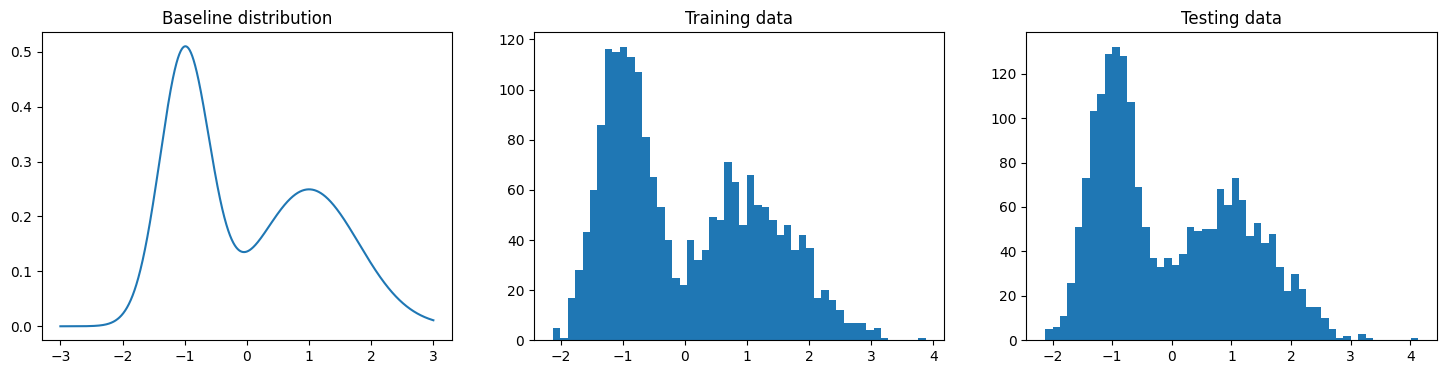

In [4]:
x = np.linspace(-3,3,2000)
base_z1 = gaussian(x, mu1, sigma1)
base_z2 = gaussian(x, mu2, sigma2)
base_z = (base_z1 + base_z2)/2

_, axes = plt.subplots(1,3, figsize=(18,4))

_ = axes[0].plot(x,base_z)
_ = axes[0].set_title('Baseline distribution')

_ = axes[1].hist(train_loader.dataset, bins=50)
_ = axes[2].hist(test_loader.dataset, bins=50)
_ = axes[1].set_title('Training data')
_ = axes[2].set_title('Testing data')

## Flow model

In [5]:
class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.weight = nn.Parameter(torch.ones(1), requires_grad=True)
        
        self.register_buffer('prior_mean', torch.zeros(1))
        self.register_buffer('prior_var', torch.ones(1))
    
    @property
    def prior(self):
        return Normal(self.prior_mean, self.prior_var)
    
    def log_prob(self, x):
        return self.prior.log_prob(x)
    
    def loss(self, z, dz_by_dx):
        log_likelihood = self.log_prob(z) + dz_by_dx.log()
        return -log_likelihood.mean()
    
    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1) * self.weight
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1) + self.bias
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        
        return z, self.loss(z, dz_by_dx)
    
    def log_det(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1) * self.weight
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1) + self.bias
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        
        return z, dz_by_dx

## Training the flow model

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        z, loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    for x in data_loader:
        z, loss = model(x)
        total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item()

def train_and_eval(model, epochs, lr, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        test_loss = eval_loss(model, test_loader)
        if epoch % 10 == 9:
            print(f'Epoch {epoch+1:3d}/{epochs} | Train Loss = {train_loss:.6f} | Test Loss = {test_loss:.6f}')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [7]:
flow = Flow1d(n_components=4)
train_losses, test_losses = train_and_eval(flow, 100, 1e-2, train_loader, test_loader)

Epoch  10/100 | Train Loss = 1.722292 | Test Loss = 1.689504
Epoch  20/100 | Train Loss = 1.559970 | Test Loss = 1.526857
Epoch  30/100 | Train Loss = 1.499347 | Test Loss = 1.467263
Epoch  40/100 | Train Loss = 1.472262 | Test Loss = 1.439592
Epoch  50/100 | Train Loss = 1.457331 | Test Loss = 1.425034
Epoch  60/100 | Train Loss = 1.448862 | Test Loss = 1.417494
Epoch  70/100 | Train Loss = 1.442680 | Test Loss = 1.410815
Epoch  80/100 | Train Loss = 1.437669 | Test Loss = 1.407443
Epoch  90/100 | Train Loss = 1.433913 | Test Loss = 1.404338
Epoch 100/100 | Train Loss = 1.431727 | Test Loss = 1.402830


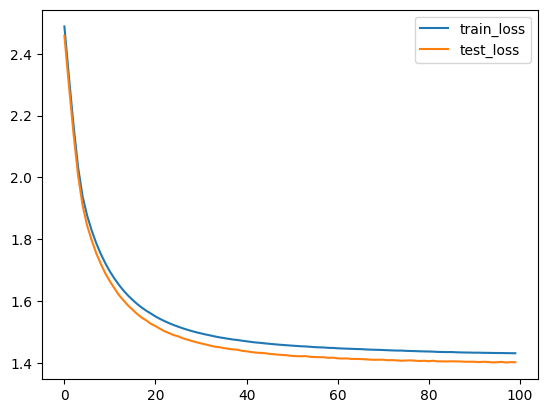

In [8]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
plt.legend()

## Visualizing the results

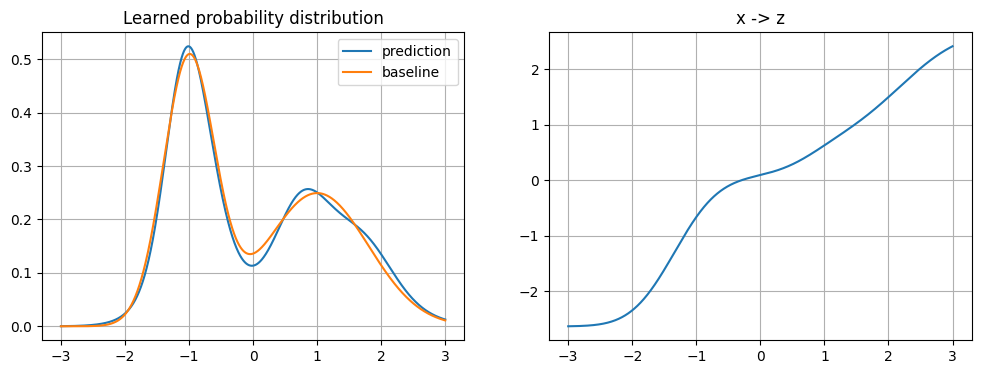

In [9]:
with torch.no_grad():
    z, dz_by_dx = flow.log_det(torch.FloatTensor(x))
    px = (flow.log_prob(z) + dz_by_dx.log()).exp().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px,label='prediction')
_ = axes[0].plot(x,base_z,label='baseline')
_ = axes[0].legend()
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

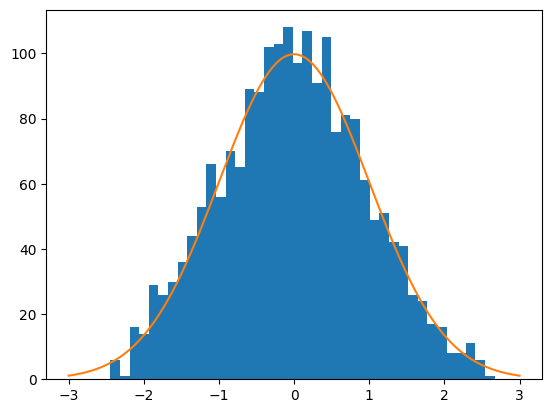

In [10]:
with torch.no_grad():
    z, dz_by_dx = flow.log_det(torch.FloatTensor(train_loader.dataset))

_ = plt.hist(z, bins=40)
_ = plt.plot(x, gaussian(x, 0, 1)*250)